In [1]:
from PIL import Image
import torch
import nopdb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [4]:
# Load an image to condition on.
img = Image.open('example_data/cube_stack.jpg')

# Produce a sample from the model.
samples = None
with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
        if x.shape[2] != 1024:
            upsampled_samples = x
        else:
            samples = x

0it [00:00, ?it/s]

In [5]:
import math
import numpy as np
new_q = attn_call.locals['q'][0].permute(1,0,2)
new_k = attn_call.locals['k'][0].permute(1,0,2)

scale = 1 / math.sqrt(math.sqrt(attn_call.locals['attn_ch']))

attention_scores = torch.einsum("b i d, b j d -> b i j", new_q, new_k) * scale

attention_probs = attention_scores.softmax(dim=-1)
avg_attn = torch.mean(attention_probs, dim=0) #mean over all heads.

pc_self_attn = avg_attn[257:,257:]
#Average attention of each point (i.e. how much did point j influence other points i on average)
#AKA it shows how important this point was to determine prediction of point i.
avg_selfattn = torch.mean(pc_self_attn, dim = 0)

print(avg_selfattn.softmax(dim=0).cpu().numpy())

#Next step is to colour code the values and attach it to the point clouds. And then visualise the points,
#not with RGB, but with the colour code depending on these values.

#Step after that, is to extract these plots from multiple timesteps and put them together as frames -> GIF
#Then we have a visualisation of how the average attention changes for the points.

[0.0009763  0.00097657 0.00097656 ... 0.00097643 0.00097632 0.00097651]


: 

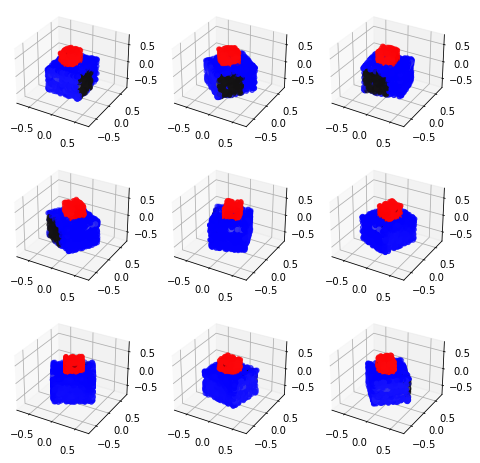

In [14]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))